In [1]:
# import necessary dependencies
import pybamm
import numpy as np
import matplotlib.pylab as plt
import scipy.optimize

# Input parameters and data fitting

This notebook will demonstrate how to use input parameters for a PyBaMM model, with application to fitting parameters to data.

## Toy model

First we will demonstrate the use of input parameters for a toy model, given by the equation

$$\frac{dy}{dt} = a y$$

with a scalar state variable $y$ and a scalar parameter $a$, and initial conditions

$$y(0) = 1$$

In [5]:
model = pybamm.BaseModel('name')
y = pybamm.Variable("y")
a = pybamm.Parameter("a")
# rhs是等式右侧的意思
model.rhs = {y: a * y}
model.initial_conditions = {y: 1}

We can print out the RHS equation for $y$, seeing that the parameter $a$ is given by a symbol with name "a"

In [6]:
print(model.rhs[y])

a * y


We can use a `pybamm.ParameterValues` object to set the parameters of the model, in this case we set $a=2$

In [4]:
params = pybamm.ParameterValues({'a': 2})
params.process_model(model)

# examine rhs equation of the model, see that "a" is replaced by the value 2
print(model.rhs[y])

2.0 * y


And then we can solve the model as normal

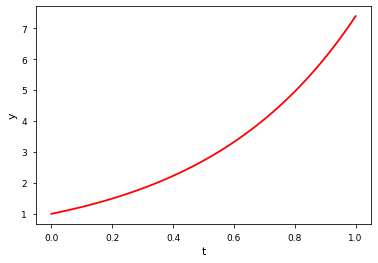

In [5]:
solver = pybamm.CasadiSolver(
    mode="fast", rtol=1e-10, atol=1e-10
)
t_eval = np.linspace(0, 1, 80)
solution = solver.solve(model, t_eval)
plt.plot(solution.t, solution.y.T)
plt.xlabel('t')
plt.ylabel('y')
plt.show()

## Input parameters

For larger, more complex models such as the DFN model in PyBaMM, there is a non-trivial cost in discretising the model and setting it up in preparation for a forward solve. However, there are many situations where a user might want to solve a similar model multiple times, each time varying one or a small number of parameters. 

In this case, using an `pybamm.InputParameter` for the parameters you wish to vary is. An `InputParameter` is not replaced by a specific value until the forward solver itself, allowing it to be varying between multiple solves.

The following demonstrates the use of an `InputParameters` for our toy model. Here we contruct a loop that evaluates the model at a number of different values for $a$.

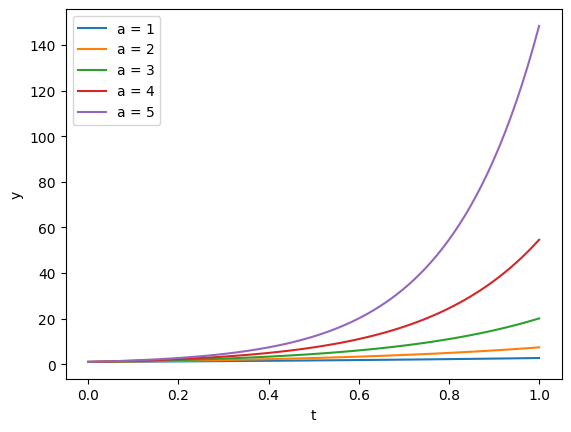

In [13]:
model = pybamm.BaseModel('name')
y = pybamm.Variable("y")
a = pybamm.InputParameter("a")
model.rhs = {y: a * y}
model.initial_conditions = {y: 1}

solver = pybamm.CasadiSolver(
    mode="fast", rtol=1e-10, atol=1e-10
)
t_eval = np.linspace(0, 1, 80)

for a_value in [1, 2, 3, 4, 5]:
    # we set the value of $a$ using the `inputs` argument of `solve()`
    solution = solver.solve(model, t_eval, inputs={'a': a_value})
    plt.plot(solution.t, solution.y.T,
             label='a = {}'.format(a_value))

plt.xlabel('t')
plt.ylabel('y')
plt.legend()
plt.show()

Often you will already have a model in place using one or more `pybamm.Parameter` objects. This would be the case if you are using one of the SPM, SPMe or DFN model provided by PaBaMM.

In this case you can convert one or more `pybamm.Parameter` objects to `pybamm.InputParameter` objects using the `pybamm.ParameterValues` class, like so:

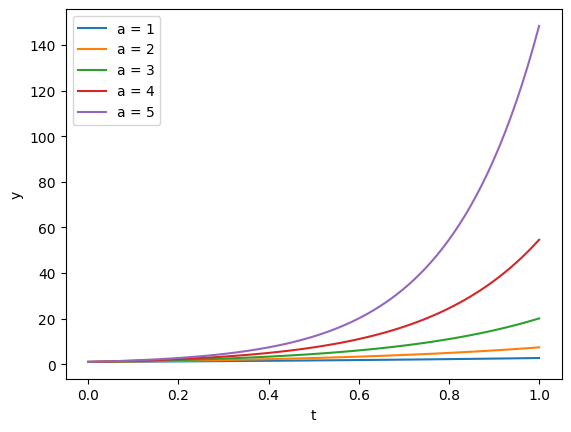

In [14]:
model = pybamm.BaseModel('name')
y = pybamm.Variable("y")
a = pybamm.Parameter("a")
model.rhs = {y: a * y}
model.initial_conditions = {y: 1}
model.variables = {"y squared": y ** 2}

# We will replace the 'a' parameter with an input parameter
params = pybamm.ParameterValues({'a': '[input]'})
params.process_model(model)

solver = pybamm.CasadiSolver(
    mode="fast", rtol=1e-10, atol=1e-10
)
t_eval = np.linspace(0, 1, 80)

for a_value in [1, 2, 3, 4, 5]:
    solution = solver.solve(model, t_eval, inputs={'a': a_value})
    plt.plot(solution.t, solution.y.T,
             label='a = {}'.format(a_value))

plt.xlabel('t')
plt.ylabel('y')
plt.legend()
plt.show()

## Using an InputParameter with the DFN model

Now lets use the same process to set the "Current function [A]" parameter of the DFN model as an input parameter

In [15]:
# load model
model = pybamm.lithium_ion.DFN()
# create geometry
geometry = model.default_geometry

# load parameter values and process model and geometry
param = model.default_parameter_values

# set "Current function" as an input parameter
param.update({"Current function [A]": "[input]"})

param.process_geometry(geometry)
param.process_model(model)

# set mesh
var = pybamm.standard_spatial_vars
var_pts = {var.x_n: 30, var.x_s: 30, var.x_p: 30, var.r_n: 10, var.r_p: 10}
mesh = pybamm.Mesh(geometry, model.default_submesh_types, var_pts)

# discretise model
disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
disc.process_model(model)

t_eval = np.linspace(0, 3600, 100)
solver = pybamm.CasadiSolver(mode="safe", atol=1e-6, rtol=1e-3)

# solve model using a value for the "Current function" parameter
solution = solver.solve(
    model, t_eval,
    inputs={"Current function [A]": 0.15652}
)

# plot
plot = pybamm.QuickPlot(
    solution,
    [
        "Negative particle concentration [mol.m-3]",
        "Electrolyte concentration [mol.m-3]",
        "Positive particle concentration [mol.m-3]",
        "Current [A]",
        "Negative electrode potential [V]",
        "Electrolyte potential [V]",
        "Positive electrode potential [V]",
        "Terminal voltage [V]",
    ],
    time_unit="seconds",
    spatial_unit="um",
)
plot.dynamic_plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=3600.0, step=36.0), Output()), _dom_classes=…

We can take advantage of the "Current function" input parameter by seeing how the "Terminal voltage" varies with this parameter.

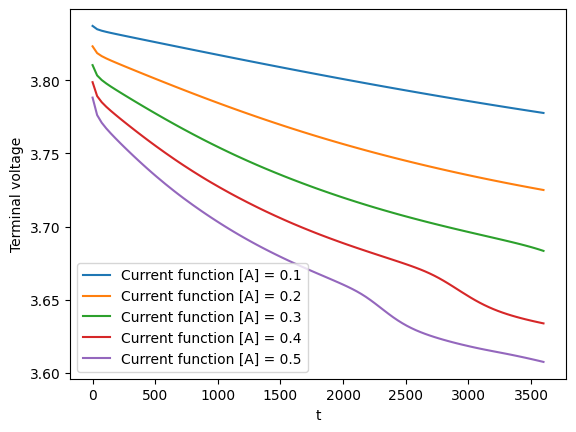

In [16]:
# let see how the "Terminal voltage" varies with "Current function"
for value in [0.1, 0.2, 0.3, 0.4, 0.5]:
    solution = solver.solve(
        model, t_eval,
        inputs={"Current function [A]": value}
    )
    plt.plot(t_eval, solution["Terminal voltage [V]"](t_eval),
             label="Current function [A] = {}".format(value))
plt.xlabel('t')
plt.ylabel('Terminal voltage')
plt.legend()
plt.show()

## Data fitting

One of the applications of using an input parameter is for parameterisation and data fitting, so lets contruct a toy example of a data fitting process using the DFN model.

First we will generate some fake data using a simulation with "Current function" = 0.2222

In [17]:
data = solver.solve(
    model, t_eval,
    inputs={"Current function [A]": 0.2222}
)["Terminal voltage"](t_eval)

Then we will construct a function that we wish to minimise. In this case we want to find the value of "Current function" that minimises the difference in "Terminal voltage" between our DFN simulation and our fake data. We therefore define a function that:
1. takes in a vector of parameters, which contains only the value of the "Current function"
2. solves the DFN model using this parameter
3. returns the sum of squared difference between the simulated "Terminal voltage", and the fake data

In [18]:
def sum_of_squares(parameters):
    print('solving for "Current function" =', parameters[0])
    simulation = solver.solve(
        model, t_eval,
        inputs={"Current function [A]": parameters[0]}
    )["Terminal voltage"](t_eval)

    return np.sum((simulation - data) ** 2)

Armed with our function that we wish to minimise, we then use the Scipy library to perform the actual minimisation.

Note that for any data fitting exercise it is likely that you will need to place bounds on the parameters that you wish to optimise, as ccertain values could lead to numerical problems with solving the equations, or the simulation terminating early. Here we will place bounds on "Current function [A]" between $(0.01, 0.6)$

In most optimisation algorithms a starting value $x_0$ is also required, and here we will use a random value between our bounds.

In [20]:
bounds = (0.01, 0.6)
x0 = np.random.uniform(low=bounds[0], high=bounds[1])

print('starting parameter is', x0)
res = scipy.optimize.minimize(
    sum_of_squares, [x0], bounds=[bounds]
)
print('recovered parameter is', res.x[0])

starting parameter is 0.27699537500488847
solving for "Current function" = 0.27699537500488847
solving for "Current function" = 0.27699538500488846
solving for "Current function" = 0.01
solving for "Current function" = 0.01000001
solving for "Current function" = 0.23088004667836973
solving for "Current function" = 0.23088005667836972
solving for "Current function" = 0.22095909224056773
solving for "Current function" = 0.22095910224056772
solving for "Current function" = 0.22223064977885654
solving for "Current function" = 0.22223065977885653
solving for "Current function" = 0.22220010355066025
solving for "Current function" = 0.22220011355066024
solving for "Current function" = 0.2221999949904589
solving for "Current function" = 0.2222000049904589
recovered parameter is 0.2221999949904589
